In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [45]:
from keras.layers import Input, Dense, Dropout
from keras.models import Model, Sequential
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.model_selection import train_test_split
import pandas as pd
from matplotlib import gridspec
from scipy import stats
from sklearn import preprocessing
import os
import keras
os.environ["CUDA_VISIBLE_DEVICES"]="2"
import random
from sklearn.model_selection import KFold

import tensorflow as tf
gpu_options = tf.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.5)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

### Functions

In [3]:
def build_data_arrays(SR, SB, gaiadata2):
    X = SR[:,3]-center_ra
    Y = SR[:,2]-center_dec

    Xb = SB[:,3]-center_ra
    Yb = SB[:,2]-center_dec
    
    Xad = gaiadata2[:, 3]-center_ra
    Yad = gaiadata2[:, 2]-center_dec

    SR = np.c_[SR[:,0],SR[:,1],X, Y, SR[:,4],SR[:,5]]
    SB = np.c_[SB[:,0],SB[:,1],Xb, Yb, SB[:,4],SB[:,5]]
    gaiadata2 = np.c_[gaiadata2[:,0],gaiadata2[:,1], Xad, Yad, gaiadata2[:,4],gaiadata2[:,5]]
    
    return SR, SB, gaiadata2

In [4]:
threshold_arr_size = 10000

In [5]:
def calc_diff(SR, SB):
    return abs(len(SR) - len(SB))

In [6]:
def find_SR_SB_pointers(pointers, increment, data_arr, start_point, end_point):
    SR = data_arr[(data_arr[:,0] > pointers[1])*(data_arr[:,0] < pointers[2])]
    SB = data_arr[(data_arr[:,0] > pointers[0])*(data_arr[:,0] < pointers[1]) + (data_arr[:,0] > pointers[2])*(data_arr[:,0] < pointers[3])]

    previous_diff = calc_diff(SR, SB)
    prev_SR, prev_SB = SR, SB
    curr_diff = previous_diff
    bottom_bool = False
    top_bool = True

    while curr_diff <= previous_diff and pointers[3] < end_point:
        previous_diff, prev_SR, prev_SB = curr_diff, SR, SB
        if bottom_bool:
            pointers[0] = max(start_point, pointers[0] - increment)
        else:
            pointers[3] = min(end_point, pointers[3] + increment)
        bottom_bool, top_bool = top_bool, bottom_bool
        SR = data_arr[(data_arr[:,0] > pointers[1])*(data_arr[:,0] < pointers[2])]
        SB = data_arr[(data_arr[:,0] > pointers[0])*(data_arr[:,0] < pointers[1]) + (data_arr[:,0] > pointers[2])*(data_arr[:,0] < pointers[3])]
        curr_diff = calc_diff(SR, SB)

    return prev_SR, prev_SB

In [7]:
def angular_distance(angle1,angle2):
    # inputs are np arrays of [ra,dec]
    deltara=np.minimum(np.minimum(np.abs(angle1[:,0]-angle2[:,0]+360),np.abs(angle1[:,0]-angle2[:,0])),\
                          np.abs(angle1[:,0]-angle2[:,0]-360))
    deltadec=np.abs(angle1[:,1]-angle2[:,1])
    return np.sqrt(deltara**2+deltadec**2)

In [8]:
#function from David's file via_machinae.py
def FilterGD1(stars):
    gd1stars=np.zeros(len(stars))
    for x in allgd1stars:
        ra=x[0]
        dec=x[1]
        pmra=x[2]
        pmdec=x[3]
    
        foundlist=angular_distance(np.dstack((stars[:,3],stars[:,2]))[0],np.array([[ra,dec]]))
        foundlist=np.sqrt(foundlist**2+(stars[:,0]-pmdec)**2+(stars[:,1]-pmra)**2)   
        foundlist=foundlist<.0001
        if len(np.argwhere(foundlist))>1:
            print(foundlist)
        if len(np.argwhere(foundlist))==1:
            gd1stars+=foundlist
    gd1stars=gd1stars.astype('bool')
    return gd1stars,stars[gd1stars]

In [62]:
def make_fractional_background(all_data, fraction):
    num = fraction*100
    frac_background = []
    for i in range(len(all_data)):
        if all_data[i][6]:
            frac_background.append(all_data[i])
        else:
            if random.randint(0, 100) < num:
                frac_background.append(all_data[i])
    frac_background = np.array(frac_background)
    frac_background = frac_background[:, :6]
    return frac_background

In [60]:
def split(data, num_splits):
    res = []
    curr = 0
    diff = len(data)//num_splits
    while curr < num_splits:
        res.append(data[curr*diff:(curr+1)*diff])
        curr += 1
    return res

### Loading data and preprocessing

In [9]:
datafile = '/data0/users/bpnachman/Gaia/gaiascan_l101.2_b58.4_ra212.7_dec55.2.npy'
gaiadata=np.load(datafile,allow_pickle=True)
gaiadata2 = np.array(gaiadata[:,[9,8,6,7,4,5]]).astype('float32') 
#pm_lat, pm_lon_coslat, lon, lat, color, mag
allgd1stars = np.load('gd1_stars.npy')
is_stream_arr, gaiadata3 = FilterGD1(gaiadata)

new_gaiadata = []
for i in range(len(gaiadata)):
    temp = np.append(gaiadata[i], is_stream_arr[i])
    new_gaiadata.append(temp)

In [10]:
gaiadata = new_gaiadata
gaiadata = np.array(gaiadata)

In [11]:
#switch 0 and 1
gaiadata2 = np.array(gaiadata[:,[8,9,6,7,4,5,10]]).astype('float32') 
gaiadata3 = np.array(gaiadata3[:,[8,9,6,7,4,5]]).astype('float32') 

In [12]:
gaiadata2 = gaiadata2[(np.abs(gaiadata2[:,0]) > 2) + (np.abs(gaiadata2[:,1]) > 2)] 
gaiadata2 = gaiadata2[(gaiadata2[:,4]>0.5) * (gaiadata2[:,4]<1)]

gaiadata3 = gaiadata3[(np.abs(gaiadata3[:,0]) > 2) + (np.abs(gaiadata3[:,1]) > 2)] 
gaiadata3 = gaiadata3[(gaiadata3[:,4]>0.5) * (gaiadata3[:,4]<1)]

### Model Averaging

In [ ]:
frac_background = make_fractional_background(gaiadata2, 0.01)


SR = frac_background[(frac_background[:,0] > -10)*(frac_background[:,0] < -8)]
SB = frac_background[(frac_background[:,0] > -11)*(frac_background[:,0] < -10)+(frac_background[:,0] > -8)*(frac_background[:,0] < -7)]
pointer1 = -10
pointer2 = -8
all_data = frac_background
stream = gaiadata3

X = np.concatenate([SR,SB])
Y = np.concatenate([np.ones(len(SR)),np.zeros(len(SB))])

myscalar = preprocessing.StandardScaler()
myscalar.fit(X)
X_scaled = myscalar.transform(X)
all_data_scaled = myscalar.transform(all_data)

X_scaled = X_scaled[Y<2]
Y = Y[Y<2]


X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.5)

print('working')

#set biases for each layer, bias_initializer
#initializers.GlorotNormal()

preds = []
preds_all = []
num_loops = 5

for curr_index in range(num_loops):
    print("on loop " + str(curr_index+1))
    model = Sequential()
    initializer =tf.keras.initializers.glorot_normal()
    model.add(Dense(256, input_dim=5, activation='relu', bias_initializer = initializer)) 
    model.add(Dropout(0.25))
    model.add(Dense(256, activation='relu', bias_initializer = initializer))
    model.add(Dropout(0.25))
    model.add(Dense(256, activation='relu', bias_initializer = initializer))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid', bias_initializer = initializer))
    optimizer = keras.optimizers.Adam(lr=1e-4)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    history = model.fit(X_train[:,1:],Y_train, epochs=200, batch_size=200,validation_data=(X_test[:,1:],Y_test), verbose = 0) 

    preds_curr = model.predict(X_test[:,1:], batch_size=int(0.1*len(X_test)))
    preds_all_curr = model.predict(all_data_scaled[:, 1:])
    
    
    preds_indices = np.argsort(preds_curr[:,0])
    preds_all_indices = np.argsort(preds_all_curr[:,0])
    
    if len(preds) == 0:
        preds = preds_curr
        preds_all = preds_all_curr
    else:
        preds = preds + preds_curr
        preds_all = preds_all + preds_all_curr

preds = [x/num_loops for x in preds]
preds_all = [x/num_loops for x in preds_all]

preds = np.array(preds)
preds_all = np.array(preds_all)
    
stars_passing_cut = []

X_test_unscaled = myscalar.inverse_transform(X_test)

preds_sorted = preds[np.argsort(preds[:,0])]
X_test_sorted = X_test_unscaled[np.argsort(preds[:,0])]
X_test_sorted = X_test_sorted[(X_test_sorted[:,0] > pointer1) * (X_test_sorted[:,0] < pointer2)]

stars_passing_cut = X_test_sorted[len(X_test_sorted) - 100:]




working
on loop 1
on loop 2
on loop 3


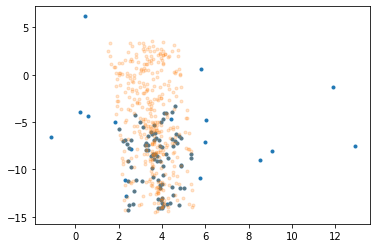

In [174]:
plt.scatter(stars_passing_cut[:,3],stars_passing_cut[:,2], marker = '.')
plt.scatter(gaiadata3[:,3], gaiadata3[:,2], marker = '.', alpha = 0.2)

plt.show()

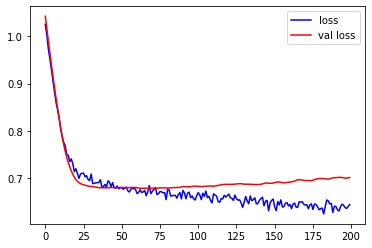

In [173]:
plt.plot(history.history['loss'], color = 'blue', label = 'loss')
plt.plot(history.history['val_loss'], color = 'red', label = 'val loss')
plt.legend()

In [169]:
'hi'

'hi'

### Mapping scores to percentiles

In [38]:
frac_background = make_fractional_background(gaiadata2, 0.5)


SR = frac_background[(frac_background[:,0] > -10)*(frac_background[:,0] < -8)]
SB = frac_background[(frac_background[:,0] > -11)*(frac_background[:,0] < -10)+(frac_background[:,0] > -8)*(frac_background[:,0] < -7)]
pointer1 = -10
pointer2 = -8
all_data = frac_background
stream = gaiadata3

X = np.concatenate([SR,SB])
Y = np.concatenate([np.ones(len(SR)),np.zeros(len(SB))])

myscalar = preprocessing.StandardScaler()
myscalar.fit(X)
X_scaled = myscalar.transform(X)
all_data_scaled = myscalar.transform(all_data)

X_scaled = X_scaled[Y<2]
Y = Y[Y<2]


X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.5)

print('working')

#set biases for each layer, bias_initializer
#initializers.GlorotNormal()

preds = []
preds_all = []
num_loops = 5

for curr_index in range(num_loops):
    print("on loop " + str(curr_index+1))
    model = Sequential()
    initializer =tf.keras.initializers.glorot_normal()
    model.add(Dense(256, input_dim=5, activation='relu', bias_initializer = initializer)) 
    model.add(Dropout(0.25))
    model.add(Dense(256, activation='relu', bias_initializer = initializer))
    model.add(Dropout(0.25))
    model.add(Dense(256, activation='relu', bias_initializer = initializer))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid', bias_initializer = initializer))
    optimizer = keras.optimizers.Adam(lr=1e-4)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    history = model.fit(X_train[:,1:],Y_train, epochs=200, batch_size=200,validation_data=(X_test[:,1:],Y_test), verbose = 0) 

    preds_curr = model.predict(X_test[:,1:], batch_size=int(0.1*len(X_test)))
    preds_all_curr = model.predict(all_data_scaled[:, 1:])
    
    
    preds_indices = np.argsort(preds_curr[:,0])
    preds_all_indices = np.argsort(preds_all_curr[:,0])
    
    for j in range(len(preds_curr)):
        preds_curr[j] = preds_indices[j]/len(preds_curr)
    for j in range(len(preds_all_curr)):
        preds_all_curr[j] = preds_all_indices[j]/len(preds_all_curr)
    
    if len(preds) == 0:
        preds = preds_curr
        preds_all = preds_all_curr
    else:
        preds = preds + preds_curr
        preds_all = preds_all + preds_all_curr

preds = [x/num_loops for x in preds]
preds_all = [x/num_loops for x in preds_all]

preds = np.array(preds)
preds_all = np.array(preds_all)
    
stars_passing_cut = []

X_test_unscaled = myscalar.inverse_transform(X_test)

preds_sorted = preds[np.argsort(preds[:,0])]
X_test_sorted = X_test_unscaled[np.argsort(preds[:,0])]
X_test_sorted = X_test_sorted[(X_test_sorted[:,0] > pointer1) * (X_test_sorted[:,0] < pointer2)]

stars_passing_cut = X_test_sorted[len(X_test_sorted) - 100:]



working
on loop 1
on loop 2
on loop 3
on loop 4
on loop 5


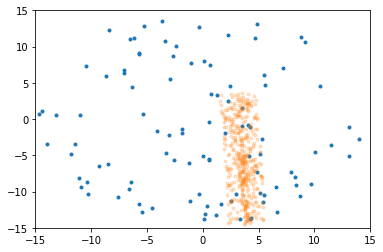

In [39]:
plt.scatter(stars_passing_cut[:,3],stars_passing_cut[:,2], marker = '.')
plt.scatter(gaiadata3[:,3], gaiadata3[:,2], marker = '.', alpha = 0.2)
plt.xlim(-15,15)
plt.ylim(-15,15)
plt.show()

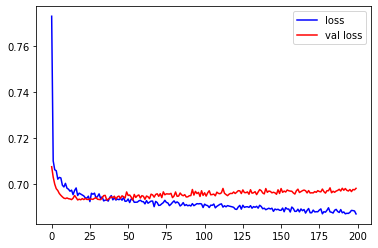

In [40]:
plt.plot(history.history['loss'], color = 'blue', label = 'loss')
plt.plot(history.history['val_loss'], color = 'red', label = 'val loss')
plt.legend()

# k-folding

In [63]:
#next steps: k folding, start with k = 2 (sk learn maybe has a function to split data into k pieces)
#for k > 2:
#1/k should be test, 1/k should be validation (k-1 choices), average amongst the k-1 choices, k-2/k for training, 
#loop within this structure 

#validation set -> use to pick the best model, lowest validation loss

In [191]:
frac_background = make_fractional_background(gaiadata2, 0.01)


SR = frac_background[(frac_background[:,0] > -10)*(frac_background[:,0] < -8)]
SB = frac_background[(frac_background[:,0] > -11)*(frac_background[:,0] < -10)+(frac_background[:,0] > -8)*(frac_background[:,0] < -7)]
pointer1 = -10
pointer2 = -8
stream = gaiadata3

X = np.concatenate([SR,SB])
Y = np.concatenate([np.ones(len(SR)),np.zeros(len(SB))])

myscalar = preprocessing.StandardScaler()
myscalar.fit(X)
X_scaled = myscalar.transform(X)

X_scaled = X_scaled[Y<2]
Y = Y[Y<2]

In [192]:
#split data into 5 sets
num_splits = 3
split_X = split(X_scaled, num_splits)
split_Y = split(Y, num_splits)

In [183]:
epochs = 20 # 200
preds_overall = []
X_test_unscaled_all = []

for test_counter in range(num_splits):
    print('outer loop')
    X_test, Y_test = split_X[test_counter], split_Y[test_counter]
    
    best_val_index = -1
    min_loss = 1
    preds_best_val = []
    
    for val_counter in range(num_splits):
        print('middle loop')
        if val_counter != test_counter:
            X_val, Y_val = split_X[val_counter], split_Y[val_counter]
            
            preds = []
            preds_all = []
            
            num_loops = 3
            
            X_train = []
            Y_train = []
            for train_counter in range(num_splits):
                if train_counter != test_counter and train_counter != val_counter:
                    if len(X_train) == 0:
                        X_train = split_X[train_counter]
                        Y_train = split_Y[train_counter]
                    else:
                        X_train += split_X[train_counter]
                        Y_train += split_Y[train_counter]
                    

            for curr_index in range(num_loops):
                print('inner loop')
    
                model = Sequential()
                initializer =tf.keras.initializers.glorot_normal()
#                 model.add(Dense(256, input_dim=5, activation='relu', bias_initializer = initializer)) 
#                 model.add(Dropout(0.25))
#                 model.add(Dense(256, activation='relu', bias_initializer = initializer))
#                 model.add(Dropout(0.25))
#                 model.add(Dense(256, activation='relu', bias_initializer = initializer))
#                 model.add(Dropout(0.25))
#                 model.add(Dense(1, activation='sigmoid', bias_initializer = initializer))

                
                model.add(Dense(64, input_dim=5, activation='relu', bias_initializer = initializer)) 
                model.add(Dense(64, activation='relu', bias_initializer = initializer))
                model.add(Dense(64, activation='relu', bias_initializer = initializer))
                model.add(Dense(1, activation='sigmoid', bias_initializer = initializer))
    
                optimizer = keras.optimizers.Adam(lr=1e-4)
                model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
                history = model.fit(X_train[:,1:],Y_train, epochs=epochs, batch_size=200, 
                                    validation_data=(X_val[:,1:], Y_val), verbose = 0) 

                preds_curr = model.predict(X_test[:,1:], batch_size=int(0.1*len(X_test)))

                if history.history['val_loss'][epochs-1] < min_loss:
                    best_val_index = val_counter
                    min_loss = history.history['val_loss'][epochs-1]
                    preds_best_val = preds_curr
    
    preds_overall.extend(preds_best_val)
    X_test_unscaled_all.extend(myscalar.inverse_transform(X_test))

        





outer loop
middle loop
middle loop
inner loop
inner loop
middle loop
inner loop
inner loop
inner loop
outer loop
middle loop
inner loop
inner loop
inner loop
middle loop
middle loop
inner loop
inner loop
inner loop
outer loop
middle loop
inner loop
inner loop
inner loop
middle loop
inner loop
inner loop
inner loop
middle loop


In [184]:
'hi'

'hi'

In [185]:
preds_overall = np.array(preds_overall)
stars_passing_cut = []
preds_sorted = preds_overall[np.argsort(preds_overall[:,0])]
X_test_unscaled_all = np.array(X_test_unscaled_all)
X_test_sorted = X_test_unscaled_all[np.argsort(preds_overall[:,0])]
X_test_sorted = X_test_sorted[(X_test_sorted[:,0] > pointer1) * (X_test_sorted[:,0] < pointer2)]

stars_passing_cut = X_test_sorted[len(X_test_sorted) - 100:]

In [186]:
stars_passing_cut

array([[ -9.773452  ,  -1.8987719 ,  -7.1840653 ,   4.7012863 ,
          0.6418381 ,  19.202312  ],
       [ -8.768139  ,  -9.71293   , -10.771715  ,  -3.8758163 ,
          0.8632221 ,  17.47594   ],
       [ -9.954659  ,   2.493963  ,   3.9072936 ,   2.9509442 ,
          0.88946533,  18.380423  ],
       [ -9.943943  ,  -2.4880972 , -11.841191  ,   1.9970554 ,
          0.8706188 ,  20.223438  ],
       [ -8.848872  ,  -2.3696017 ,  -8.371723  ,   3.3277628 ,
          0.66004944,  18.849108  ],
       [ -8.02117   ,  -1.9622903 , -11.943249  ,   5.0091934 ,
          0.83919144,  19.903296  ],
       [ -9.173566  ,  -3.0429978 ,  10.265479  ,  10.865868  ,
          0.63355064,  18.00756   ],
       [ -8.059751  ,  -2.7188258 , -13.334815  ,  -1.0787599 ,
          0.8339405 ,  19.397423  ],
       [ -9.858935  ,  -1.9737256 ,  -8.820823  ,   4.2929797 ,
          0.6592293 ,  18.08076   ],
       [ -8.079211  ,  -1.5754238 ,  -8.709589  ,   6.41646   ,
          0.6560745 ,  18.6

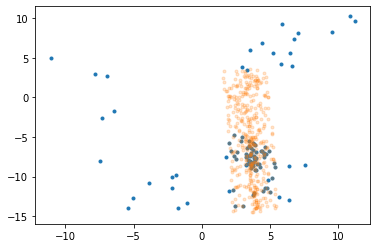

In [188]:
plt.scatter(stars_passing_cut[:,3],stars_passing_cut[:,2], marker = '.')
plt.scatter(gaiadata3[:,3], gaiadata3[:,2], marker = '.', alpha = 0.2)

plt.show()

In [ ]:
'hi'

In [189]:
frac_background = make_fractional_background(gaiadata2, 0.01)


SR = frac_background[(frac_background[:,0] > -10)*(frac_background[:,0] < -8)]
SB = frac_background[(frac_background[:,0] > -11)*(frac_background[:,0] < -10)+(frac_background[:,0] > -8)*(frac_background[:,0] < -7)]
pointer1 = -10
pointer2 = -8
stream = gaiadata3

X = np.concatenate([SR,SB])
Y = np.concatenate([np.ones(len(SR)),np.zeros(len(SB))])

myscalar = preprocessing.StandardScaler()
myscalar.fit(X)
X_scaled = myscalar.transform(X)

X_scaled = X_scaled[Y<2]
Y = Y[Y<2]

In [190]:
#split data into 5 sets
num_splits = 5
split_X = split(X_scaled, num_splits)
split_Y = split(Y, num_splits)

In [ ]:
epochs = 200 
preds_overall = []
X_test_unscaled_all = []

for test_counter in range(num_splits):
    print('outer loop')
    X_test, Y_test = split_X[test_counter], split_Y[test_counter]
    
    best_val_index = -1
    min_loss = 1
    preds_best_val = []
    
    for val_counter in range(num_splits):
        print('middle loop')
        if val_counter != test_counter:
            X_val, Y_val = split_X[val_counter], split_Y[val_counter]
            
            preds = []
            preds_all = []
            
            num_loops = 3
            
            X_train = []
            Y_train = []
            for train_counter in range(num_splits):
                if train_counter != test_counter and train_counter != val_counter:
                    if len(X_train) == 0:
                        X_train = split_X[train_counter]
                        Y_train = split_Y[train_counter]
                    else:
                        X_train += split_X[train_counter]
                        Y_train += split_Y[train_counter]
                    

            for curr_index in range(num_loops):
                print('inner loop')
    
                model = Sequential()
                initializer =tf.keras.initializers.glorot_normal()
#                 model.add(Dense(256, input_dim=5, activation='relu', bias_initializer = initializer)) 
#                 model.add(Dropout(0.25))
#                 model.add(Dense(256, activation='relu', bias_initializer = initializer))
#                 model.add(Dropout(0.25))
#                 model.add(Dense(256, activation='relu', bias_initializer = initializer))
#                 model.add(Dropout(0.25))
#                 model.add(Dense(1, activation='sigmoid', bias_initializer = initializer))

                
                model.add(Dense(64, input_dim=5, activation='relu', bias_initializer = initializer)) 
                model.add(Dense(64, activation='relu', bias_initializer = initializer))
                model.add(Dense(64, activation='relu', bias_initializer = initializer))
                model.add(Dense(1, activation='sigmoid', bias_initializer = initializer))
    
                optimizer = keras.optimizers.Adam(lr=1e-4)
                model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
                history = model.fit(X_train[:,1:],Y_train, epochs=epochs, batch_size=200, 
                                    validation_data=(X_val[:,1:], Y_val), verbose = 0) 

                preds_curr = model.predict(X_test[:,1:], batch_size=int(0.1*len(X_test)))

                if history.history['val_loss'][epochs-1] < min_loss:
                    best_val_index = val_counter
                    min_loss = history.history['val_loss'][epochs-1]
                    preds_best_val = preds_curr
    
    preds_overall.extend(preds_best_val)
    X_test_unscaled_all.extend(myscalar.inverse_transform(X_test))

        




